Making the datasets

In [2]:
import sys 
sys.path.append('../')
import numpy as np
DEVICE = 'cuda'
import torch
from torch.nn import functional as F
from tqdm.auto import tqdm

from src.data.registry import exact_patches_sl_tuffc_ndl, exact_patches_sl_tuffc_prostate

noisy_train_set_for_evaluation = exact_patches_sl_tuffc_-prostate(split='train')
noisy_train_set_for_training = exact_patches_sl_tuffc_prostate(split='train')
clean_train_set = exact_patches_sl_tuffc_ndl(split='train')
test_set = exact_patches_sl_tuffc_ndl(split='test')
val_set = exact_patches_sl_tuffc_ndl(split='val')

from src.data.exact.transforms import TransformV3, UltrasoundArrayAugmentation, TensorImageAugmentation, MultiTransform

eval_transform = TransformV3()

augmentations_weak = TransformV3(
    tensor_transform=TensorImageAugmentation(
        random_erasing=False,
        random_invert=True,
        random_horizontal_flip=True,
        random_vertical_flip=True,
        random_resized_crop=True,
        random_resized_crop_scale=(0.9, 1.0),
        random_affine_translation=[0, 0],
    )
)

augmentations_strong = TransformV3(
    tensor_transform=TensorImageAugmentation(
        random_erasing=True,
        random_invert=True,
        random_horizontal_flip=True,
        random_vertical_flip=True,
        random_affine_translation=[0.1, 0.1],
        random_resized_crop=True,
        random_resized_crop_scale=(0.7, 1.0),
        # random_affine_rotation=5,
    ),
    us_augmentation=UltrasoundArrayAugmentation(
        random_phase_shift=True, 
        random_phase_distort=True, 
        random_envelope_distort=True, 
        random_envelope_distort_strength=1, 

    ),
)

augmentations = MultiTransform(
    augmentations_weak,
    augmentations_weak,
    augmentations_strong,
    augmentations_strong,
)

noisy_train_set_for_evaluation.patch_transform = eval_transform
noisy_train_set_for_training.patch_transform = augmentations
clean_train_set.patch_transform = eval_transform
test_set.patch_transform = eval_transform
val_set.patch_transform = eval_transform

NameError: name 'exact_patches_sl_tuffc_' is not defined

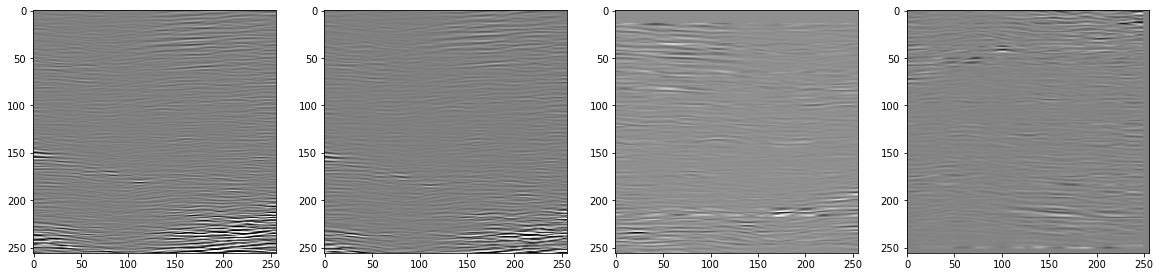

In [19]:
# let's look at the weak vs. strong augmentations
import matplotlib.pyplot as plt
import numpy as np

X1, X2, X3, X4 = noisy_train_set_for_training[0][0]

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs[0].imshow(X1[0], cmap='gray')
axs[1].imshow(X2[0], cmap='gray')
axs[2].imshow(X3[0], cmap='gray')
axs[3].imshow(X4[0], cmap='gray')
plt.show()

Baseline tests: How does linear evaluation perform?

In [20]:
from src.modeling.registry import resnet10_pretrained, vicreg_resnet10_pretrn_allcntrs_noPrst_ndl_crop
model = vicreg_resnet10_pretrn_allcntrs_noPrst_ndl_crop(2).backbone.to(DEVICE)

In [21]:
def extract_features(dataset, model, device=DEVICE): 
    model.eval()
    from torch.utils.data import DataLoader
    import torch 
    all_feats = [] 
    all_labels = []
    for batch in tqdm(DataLoader(dataset, 64, shuffle=False, num_workers=0)):
        X, y, *_ = batch 
        with torch.inference_mode(): 
            feats = model(X.to(device)).detach().cpu()
            all_feats.append(feats)
            all_labels.append(y)

    return torch.cat(all_feats).numpy(), torch.cat(all_labels).numpy()

Needle region training for lin eval

In [43]:
# X_train, y_train = extract_features(clean_train_set, model)
# X_val, y_val = extract_features(val_set, model)
# X_test, y_test = extract_features(test_set, model)
import pandas as pd

X_train = torch.load('/home/paulw/projects/TRUSnet-1/features/exact_tuffc_ndl_features/train_feats.pt').numpy()
y_train = pd.read_csv('/home/paulw/projects/TRUSnet-1/features/exact_tuffc_ndl_features/train_meta.csv').y
X_val = torch.load('/home/paulw/projects/TRUSnet-1/features/exact_tuffc_ndl_features/val_feats.pt').numpy()
y_val = pd.read_csv('/home/paulw/projects/TRUSnet-1/features/exact_tuffc_ndl_features/val_meta.csv').y
X_test = torch.load('/home/paulw/projects/TRUSnet-1/features/exact_tuffc_ndl_features/test_feats.pt').numpy()
y_test = pd.read_csv('/home/paulw/projects/TRUSnet-1/features/exact_tuffc_ndl_features/test_meta.csv').y

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=3000)
lr.fit(X_train, y_train)

y_hat_test = lr.predict_proba(X_test)[:, 1]
y_hat_val = lr.predict_proba(X_val)[:, 1]

from sklearn.metrics import roc_auc_score
print('test')
info_test = pd.read_csv('/home/paulw/projects/TRUSnet-1/features/exact_tuffc_ndl_features/test_meta.csv')
info_test['y_hat'] = y_hat_test
print('patchwise auroc', roc_auc_score(info_test.y, info_test.y_hat))
core_out = info_test.groupby('core_specifier').y_hat.mean()
core_label = info_test.groupby('core_specifier').y.mean()
print('corewise_auroc', roc_auc_score(core_label, core_out))

print('val')
info_val = pd.read_csv('/home/paulw/projects/TRUSnet-1/features/exact_tuffc_ndl_features/val_meta.csv')
info_val['y_hat'] = y_hat_val
print('patchwise auroc', roc_auc_score(info_val.y, info_val.y_hat))
core_out = info_val.groupby('core_specifier').y_hat.mean()
core_label = info_val.groupby('core_specifier').y.mean()
print('corewise_auroc', roc_auc_score(core_label, core_out))


test
patchwise auroc 0.7462113706458888
corewise_auroc 0.878780718336484
val
patchwise auroc 0.5954207109913363
corewise_auroc 0.6330759853718


Prostate region training for lin eval

In [47]:
# X_train, y_train = extract_features(clean_train_set, model)
# X_val, y_val = extract_features(val_set, model)
# X_test, y_test = extract_features(test_set, model)
import pandas as pd

X_train = torch.load('/home/paulw/projects/TRUSnet-1/features/exact_tuffc_prostate_features/train_feats.pt').numpy()
y_train = pd.read_csv('/home/paulw/projects/TRUSnet-1/features/exact_tuffc_prostate_features/train_meta.csv').y
X_val = torch.load('/home/paulw/projects/TRUSnet-1/features/exact_tuffc_ndl_features/val_feats.pt').numpy()
y_val = pd.read_csv('/home/paulw/projects/TRUSnet-1/features/exact_tuffc_ndl_features/val_meta.csv').y
X_test = torch.load('/home/paulw/projects/TRUSnet-1/features/exact_tuffc_ndl_features/test_feats.pt').numpy()
y_test = pd.read_csv('/home/paulw/projects/TRUSnet-1/features/exact_tuffc_ndl_features/test_meta.csv').y

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=3000)
lr.fit(X_train, y_train)

y_hat_test = lr.predict_proba(X_test)[:, 1]
y_hat_val = lr.predict_proba(X_val)[:, 1]

from sklearn.metrics import roc_auc_score
print('test')
info_test = pd.read_csv('/home/paulw/projects/TRUSnet-1/features/exact_tuffc_ndl_features/test_meta.csv')
info_test['y_hat'] = y_hat_test
print('patchwise auroc', roc_auc_score(info_test.y, info_test.y_hat))
core_out = info_test.groupby('core_specifier').y_hat.mean()
core_label = info_test.groupby('core_specifier').y.mean()
print('corewise_auroc', roc_auc_score(core_label, core_out))

print('val')
info_val = pd.read_csv('/home/paulw/projects/TRUSnet-1/features/exact_tuffc_ndl_features/val_meta.csv')
info_val['y_hat'] = y_hat_val
print('patchwise auroc', roc_auc_score(info_val.y, info_val.y_hat))
core_out = info_val.groupby('core_specifier').y_hat.mean()
core_label = info_val.groupby('core_specifier').y.mean()
print('corewise_auroc', roc_auc_score(core_label, core_out))

test
patchwise auroc 0.7595058577241917
corewise_auroc 0.8962665406427222
val
patchwise auroc 0.6085968023073007
corewise_auroc 0.6631450629825275


In [69]:
import pandas as pd

norms = {}
def get_xy(X, info, fit_norm=False, additionals=['position_0', 'psa', 'age', 'family_history']):
    for additional in additionals:
        position = info[additional] 
        position = position.fillna(0)
        if fit_norm: 
            mean = position.mean(axis=0)
            std = position.std(axis=0)
            norms[additional] = (mean, std)
        else:
            mean, std = norms[additional]
        position = (position - mean) / std if fit_norm else (position - mean) / std
        position = position.values.reshape(-1, 1)
        X = np.concatenate([X, position], axis=1)

    return X, info.y

X_train = torch.load('/home/paulw/projects/TRUSnet-1/features/exact_tuffc_prostate_features/train_feats.pt').numpy()
info_train = pd.read_csv('/home/paulw/projects/TRUSnet-1/features/exact_tuffc_prostate_features/train_meta.csv')

X_val = torch.load('/home/paulw/projects/TRUSnet-1/features/exact_tuffc_ndl_features/val_feats.pt').numpy()
info_val = pd.read_csv('/home/paulw/projects/TRUSnet-1/features/exact_tuffc_ndl_features/val_meta.csv')

X_test = torch.load('/home/paulw/projects/TRUSnet-1/features/exact_tuffc_ndl_features/test_feats.pt').numpy()
info_test = pd.read_csv('/home/paulw/projects/TRUSnet-1/features/exact_tuffc_ndl_features/test_meta.csv')

X_train, y_train = get_xy(X_train, info_train, fit_norm=True)
X_val, y_val = get_xy(X_val, info_val)
X_test, y_test = get_xy(X_test, info_test)

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=3000)
lr.fit(X_train, y_train)

y_hat_test = lr.predict_proba(X_test)[:, 1]
y_hat_val = lr.predict_proba(X_val)[:, 1]

from sklearn.metrics import roc_auc_score
print('test')
info_test = pd.read_csv('/home/paulw/projects/TRUSnet-1/features/exact_tuffc_ndl_features/test_meta.csv')
info_test['y_hat'] = y_hat_test
print('patchwise auroc', roc_auc_score(info_test.y, info_test.y_hat))
core_out = info_test.groupby('core_specifier').y_hat.mean()
core_label = info_test.groupby('core_specifier').y.mean()
print('corewise_auroc', roc_auc_score(core_label, core_out))

print('val')
info_val = pd.read_csv('/home/paulw/projects/TRUSnet-1/features/exact_tuffc_ndl_features/val_meta.csv')
info_val['y_hat'] = y_hat_val
print('patchwise auroc', roc_auc_score(info_val.y, info_val.y_hat))
core_out = info_val.groupby('core_specifier').y_hat.mean()
core_label = info_val.groupby('core_specifier').y.mean()
print('corewise_auroc', roc_auc_score(core_label, core_out))

test
patchwise auroc 0.7017076399500708
corewise_auroc 0.7155009451795842
val
patchwise auroc 0.6108176760480487
corewise_auroc 0.6407964242177977


## Finetuning with either prostate or needle train set

In [55]:
model

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

patchwise auroc 0.7462113706458888
corewise_auroc 0.878780718336484


0.7462113706458888

patchwise auroc 0.7462113706458888
corewise_auroc 0.878780718336484


0.878780718336484

In [16]:
X_train = torch.load('/home/paulw/projects/TRUSnet-1/features/exact_tuffc_prostate_features/train_feats.pt').numpy()
y_train = pd.read_csv('/home/paulw/projects/TRUSnet-1/features/exact_tuffc_prostate_features/train_meta.csv').y

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=3000)
lr.fit(X_train, y_train)

y_hat_test = lr.predict_proba(X_test)[:, 1]
from sklearn.metrics import roc_auc_score
print('test roc', roc_auc_score(y_test, y_hat_test))

y_hat_val = lr.predict_proba(X_val)[:, 1]
from sklearn.metrics import roc_auc_score
print('val roc', roc_auc_score(y_val, y_hat_val))



test roc 0.7595058577241917
val roc 0.6085968023073007


In [24]:
from src.data.registry import exact_patches_sl_tuffc_ndl, exact_patches_sl_tuffc_prostate

dataset = exact_patches_sl_tuffc_ndl('train')

Indexing Patches: 100%|██████████| 528/528 [00:00<00:00, 58839.27it/s]


In [26]:
dataset[0][0]

tensor([[[0.4641, 0.4796, 0.4898,  ..., 0.9381, 0.8918, 0.8209],
         [0.6247, 0.6361, 0.6435,  ..., 0.1944, 0.2247, 0.2710],
         [0.6000, 0.5777, 0.5631,  ..., 0.3258, 0.3287, 0.3331],
         ...,
         [0.5284, 0.5271, 0.5262,  ..., 0.4807, 0.4783, 0.4746],
         [0.4999, 0.4961, 0.4936,  ..., 0.5133, 0.5149, 0.5173],
         [0.5305, 0.5459, 0.5559,  ..., 0.5109, 0.5136, 0.5178]]])

In [17]:
from sklearn.neural_network import MLPClassifier
lr = MLPClassifier(hidden_layer_sizes=(256, 128, 64))
lr.fit(X_train, y_train)

y_hat_test = lr.predict_proba(X_test)[:, 1]
from sklearn.metrics import roc_auc_score
print('test roc', roc_auc_score(y_test, y_hat_test))

y_hat_val = lr.predict_proba(X_val)[:, 1]
from sklearn.metrics import roc_auc_score
print('val roc', roc_auc_score(y_val, y_hat_val))

test roc 0.6495827106177898
val roc 0.5355421764455163


/home/paulw/anaconda3/envs/exact/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:709: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [10]:
torch.save(model.state_dict(), 'tmp.pth')

In [12]:
model

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [1]:
len(clean_train_set)

NameError: name 'clean_train_set' is not defined

In [20]:
X.shape, y.shape

(torch.Size([28, 512]), torch.Size([28]))

In [4]:
from torch.utils.data import DataLoader
train_loader_for_loss_evaluation = DataLoader(
    noisy_train_set_for_evaluation,
    batch_size=64,
    shuffle=False,
    num_workers=16, 
    pin_memory=True,
    prefetch_factor=2, 
    persistent_workers=True
)

In [5]:
def kl_divergence(p, q):
    return (p * ((p+1e-10) / (q+1e-10)).log()).sum(dim=1)

def jensen_shannon_divergence(p,q):
    m = (p+q)/2
    return 0.5*kl_divergence(p, m) + 0.5*kl_divergence(q, m)

def compute_losses(model, loader, criterion, device): 
    model.eval()
    with torch.inference_mode():
        from src.utils.metrics import OutputCollector
        oc = OutputCollector()
        for batch in tqdm(loader, desc='Computing losses'):
            x, y, info, *_ = batch
            x = x.to(device)
            y = y.to(device)
            y = F.one_hot(y, num_classes=2).float()
            y_hat = model(x).softmax(-1)
            loss = criterion(y_hat, y)
            oc.collect_batch(
                {'loss': loss, 'y_hat': y_hat, 'y': y, **info}, 
            )
        out = oc.compute()
    return out['loss'], out

In [6]:
model.to(DEVICE)
crit = torch.nn.CrossEntropyLoss(reduction='none')
losses, out = compute_losses(model, train_loader_for_loss_evaluation, crit, DEVICE)

Computing losses:   0%|          | 0/3206 [00:00<?, ?it/s]

In [19]:
def to_dataframe(out): 
    import pandas as pd
    columns = {}
    for name, value in out.items(): 
        # if the array value has multiple columns, split it
        if isinstance(value, torch.Tensor):
            value = value.cpu().numpy()
        if isinstance(value, np.ndarray) and value.ndim == 2:
            for i in range(value.shape[1]):
                columns[f'{name}_{i}'] = value[:, i]
        else:
            columns[name] = value
    #df = pd.DataFrame(columns)
    return pd.DataFrame(columns)

df = to_dataframe(out)

<AxesSubplot:>

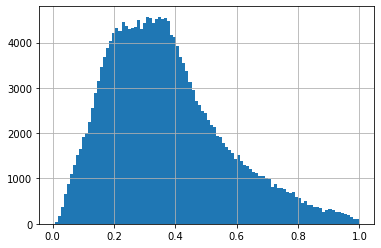

In [20]:
df.y_hat_1.hist(bins=100)

<AxesSubplot:title={'center':'Loss distribution by class'}, xlabel='number of samples', ylabel='loss'>

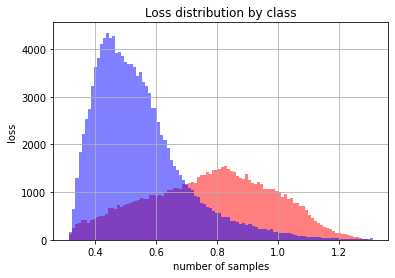

In [21]:
plt.figure()
plt.ylabel('loss')
plt.xlabel('number of samples')
plt.title('Loss distribution by class')
df.query("y_1 == 1").loss.hist(bins=100, color='r', alpha=0.5, label='cancer')
df.query("y_1 == 0").loss.hist(bins=100, color='b', alpha=0.5, label='benign')

In [22]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=2, covariance_type='full')

gmm.fit(df['loss'].values.reshape(-1, 1))

GaussianMixture(n_components=2)

In [23]:
probs = gmm.predict_proba(df['loss'].values.reshape(-1, 1))

prob_clean = probs[:, gmm.means_.argmin()]
prob_noisy = probs[:, gmm.means_.argmax()]

df['prob_low_loss'] = prob_clean
df['prob_high_loss'] = prob_noisy

df['pct_cancer'].fillna(0, inplace=True)
df = df.join(df.groupby("patient_specifier").pct_cancer.mean(), on='patient_specifier', how='left', rsuffix='_patient_mean')

tmp = df['pct_cancer_patient_mean'].copy()
tmp = tmp / 100
tmp.loc[df['y_1'] == 1] = 1 - tmp.loc[df['y_1'] == 1] 
tmp.loc[df['y_1'] == 0] += 1e-2

df['noise_prior'] = tmp

In [54]:
df

,loss,y_hat_0,y_hat_1,y_0,y_1,patient_id,path_on_server,center,loc,grade,...,position_0,position_1,position_2,position_3,needle_intersection,prostate_intersection,prob_low_loss,prob_high_loss,pct_cancer_patient_mean,noise_prior
0,0.582445,0.617602,0.382398,1.0,0.0,12,/med-i_data/Data/Exact_Ultrasound/data/full_da...,CRCEO,LBM,Benign,...,3,8,25,30,0.0,0.932503,0.912764,0.087236,25.028377,0.260284
1,0.626406,0.569129,0.430871,1.0,0.0,12,/med-i_data/Data/Exact_Ultrasound/data/full_da...,CRCEO,LBM,Benign,...,3,8,26,31,0.0,0.954729,0.806113,0.193887,25.028377,0.260284
2,0.578689,0.621866,0.378134,1.0,0.0,12,/med-i_data/Data/Exact_Ultrasound/data/full_da...,CRCEO,LBM,Benign,...,3,8,27,32,0.0,0.966823,0.918443,0.081557,25.028377,0.260284
3,0.492787,0.725594,0.274407,1.0,0.0,12,/med-i_data/Data/Exact_Ultrasound/data/full_da...,CRCEO,LBM,Benign,...,3,8,28,33,0.0,0.965189,0.979645,0.020355,25.028377,0.260284
4,0.498689,0.718044,0.281956,1.0,0.0,12,/med-i_data/Data/Exact_Ultrasound/data/full_da...,CRCEO,LBM,Benign,...,3,8,29,34,0.0,0.956037,0.977863,0.022137,25.028377,0.260284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205151,1.033935,0.797246,0.202754,0.0,1.0,628,/med-i_data/Data/Exact_Ultrasound/data/full_da...,UVA,RMM,GS10,...,23,28,31,36,0.0,0.901124,0.000003,0.999997,100.000000,0.000000
205152,1.001418,0.771784,0.228216,0.0,1.0,628,/med-i_data/Data/Exact_Ultrasound/data/full_da...,UVA,RMM,GS10,...,23,28,32,37,0.0,0.901124,0.000015,0.999985,100.000000,0.000000
205153,0.900056,0.689129,0.310871,0.0,1.0,628,/med-i_data/Data/Exact_Ultrasound/data/full_da...,UVA,RMM,GS10,...,23,28,33,38,0.0,0.901124,0.001002,0.998998,100.000000,0.000000
205154,0.803103,0.604505,0.395495,0.0,1.0,628,/med-i_data/Data/Exact_Ultrasound/data/full_da...,UVA,RMM,GS10,...,23,28,34,39,0.0,0.901124,0.030949,0.969051,100.000000,0.000000


In [64]:
(df.noise_prior)

127771

In [71]:
(df.noise_prior * df.prob_high_loss).sort_values().index

Int64Index([205155, 196152, 196153, 196154, 196155, 196156, 196157, 196158,
            196151, 196159,
            ...
            143166, 143233, 143191, 143220, 143206, 143165, 143221, 143205,
            143192, 143234],
           dtype='int64', length=205156)

In [ ]:
df['pct_cancer'].fillna(0, inplace=True)
df_new = df.join(df.groupby("patient_specifier").pct_cancer.mean(), on='patient_specifier', how='left', rsuffix='_patient_mean')

In [ ]:
df = df_new

In [ ]:
df['pct_cancer_patient_mean'].corr(df['loss'])

0.46414512083160553

In [ ]:
import pandas as pd
pd.qcut(df['loss'], 10).value_counts()

(0.313, 0.404]    20516
(0.404, 0.448]    20516
(0.49, 0.536]     20516
(0.585, 0.646]    20516
(0.73, 0.827]     20516
(0.948, 1.31]     20516
(0.448, 0.49]     20515
(0.536, 0.585]    20515
(0.646, 0.73]     20515
(0.827, 0.948]    20515
Name: loss, dtype: int64

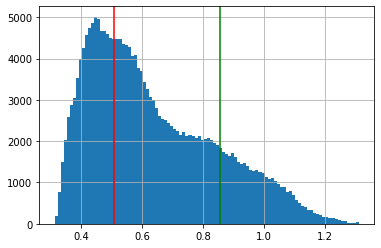

In [ ]:
df.loss.hist(bins=100)
# add vertical line for center of each gmm
plt.axvline(gmm.means_[0], color='g')
plt.axvline(gmm.means_[1], color='r')

In [36]:
gmm.predict_proba(np.array(1).reshape(-1, 1))

array([[9.99984223e-01, 1.57772723e-05]])

(array([  4.,   9.,   3.,   8.,  12.,  14.,  21.,  23.,  30.,  48.,  61.,
         66.,  96.,  95., 105., 150., 184., 199., 221., 231., 233., 259.,
        330., 314., 298., 312., 320., 316., 306., 313., 280., 277., 245.,
        208., 220., 189., 153., 162., 136., 126., 126., 131., 120., 104.,
        127., 110., 108., 133., 122., 119., 113., 139., 134., 118., 119.,
        108., 136., 108., 104., 115., 101., 105.,  85.,  88.,  71.,  72.,
         65.,  70.,  47.,  43.,  35.,  33.,  23.,  32.,  22.,  23.,  13.,
         13.,  17.,  13.,  10.,   9.,   2.,   9.,   9.,   3.,   6.,   4.,
          2.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,
          1.]),
 array([0.19146391, 0.20391333, 0.21636275, 0.22881216, 0.24126158,
        0.253711  , 0.26616042, 0.27860984, 0.29105926, 0.30350868,
        0.3159581 , 0.32840751, 0.34085693, 0.35330635, 0.36575577,
        0.37820519, 0.39065461, 0.40310403, 0.41555344, 0.42800286,
        0.44045228, 0.4529017 , 0.46535112, 0.

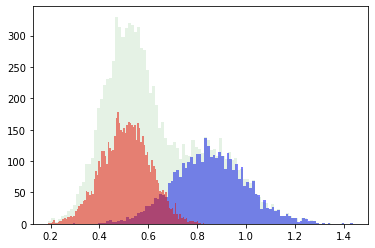

In [ ]:
# sample from the gmm
X, y = gmm.sample(10000)
plt.hist(X[y == 0], bins=100, color='b', alpha=0.5, label='clean')
plt.hist(X[y == 1], bins=100, color='r', alpha=0.5, label='noisy')
plt.hist(X, bins=100, color='g', alpha=0.1, label='all')

In [ ]:
df.columns

Index(['loss', 'y_hat_0', 'y_hat_1', 'y_0', 'y_1', 'patient_id',
       'path_on_server', 'center', 'loc', 'grade', 'age', 'family_history',
       'psa', 'pct_cancer', 'primary_grade', 'secondary_grade',
       'patient_specifier', 'core_specifier', 'position_0', 'position_1',
       'position_2', 'position_3', 'needle_intersection',
       'prostate_intersection'],
      dtype='object')

In [ ]:
R = sum(losses < losses.mean()) / len(losses)

In [ ]:
def get_labeled_and_unlabeled_sets(dataset, losses):
    assert len(losses) == len(dataset)
    indices = np.array(range(len(dataset)))
    labels = np.array(dataset.labels).astype('int')

    # compute filter rate for each class
    R = sum(losses < losses.mean()) / len(losses) 

    all_clean_indices = []
    all_noise_indices = []

    for class_idx in np.unique(labels): 
        class_indices = indices[labels == class_idx]
        class_losses = losses[labels == class_idx]

        num_clean_samples_for_class = int(R * len(class_indices))
        clean_indices = class_indices[class_losses.argsort()][:num_clean_samples_for_class]
        noise_indices = class_indices[class_losses.argsort()][num_clean_samples_for_class:]

        all_clean_indices.append(clean_indices)
        all_noise_indices.append(noise_indices)

    all_clean_indices = np.concatenate(all_clean_indices)
    all_noise_indices = np.concatenate(all_noise_indices)

    # make sure there is no overlap between clean and noise indices
    assert len(set(all_clean_indices).intersection(set(all_noise_indices))) == 0

    # the labeled set uses the loss as to get "clean probabilities"
    clean_prob = 1 - losses[all_clean_indices]
    clean_prob[clean_prob > 0.5] = 1

    class LabeledDataset(torch.utils.data.Dataset):
        def __init__(self, dataset, indices, clean_prob):
            self.dataset = dataset
            self.indices = indices
            self.clean_prob = clean_prob
            self.labels = np.array(dataset.labels).astype('int')[indices]

        def __getitem__(self, index):
            return self.dataset[self.indices[index]] + (self.clean_prob[index],)

        def __len__(self):
            return len(self.indices)

    class UnlabeledDataset(torch.utils.data.Dataset):
        def __init__(self, dataset, indices):
            self.dataset = dataset
            self.indices = indices

        def __getitem__(self, index):
            return self.dataset[self.indices[index]]

        def __len__(self):
            return len(self.indices)

    labeled_dataset = LabeledDataset(dataset, all_clean_indices, clean_prob)
    unlabeled_dataset = UnlabeledDataset(dataset, all_noise_indices)

    return labeled_dataset, unlabeled_dataset

def get_weighted_sampler(dataset): 
    labels = np.array(dataset.labels).astype('int')
    class_weights = 1 / np.bincount(labels)
    sample_weights = class_weights[labels]
    sample_weights = torch.from_numpy(sample_weights)
    sampler = torch.utils.data.WeightedRandomSampler(sample_weights, len(sample_weights))
    return sampler

In [ ]:
labeled_dataset, unlabeled_dataset = get_labeled_and_unlabeled_sets(noisy_train_set_for_training, losses)

labeled_loader = DataLoader(
    labeled_dataset,
    batch_size=64,
    sampler=get_weighted_sampler(labeled_dataset),
    num_workers=8,
    pin_memory=True,
    drop_last=True,
)

unlabeled_loader = DataLoader(
    unlabeled_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=8,
    pin_memory=True,
    drop_last=True
)

In [ ]:
T = 0.5
ALPHA = 4
WARMUP = 10
BASE_LAMBDA = 25


# def get_lambda(current, warm_up, rampup_length=16, base_lambda=25):
    # current = np.clip((current - warm_up) / rampup_length, 0.0, 1.0)
    # return base_lambda * float(current)


def log(d): 
    import json
    print(json.dumps(d))


from torchmetrics import MeanMetric

def test(epoch, test_loader, model, device):
    print(f"Testing -- epoch {epoch}")
    model.eval()
    from src.utils.metrics import OutputCollector

    oc = OutputCollector()
    with torch.no_grad():
        for batch_idx, (inputs, targets, info) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            oc.collect_batch(
                {
                    "logits": outputs,
                    "targets": targets,
                    "core_specifier": info["core_specifier"],
                    "position": info["position"],
                    "prostate_intersection": info["prostate_intersection"],
                    "needle_intersection": info["needle_intersection"],
                    "probs": torch.softmax(outputs, dim=-1),
                }
            )

    out = oc.compute()
    from torchmetrics.functional import auroc

    auroc_ = auroc(out["logits"], out["targets"], num_classes=2, average="macro")
    return {
        "auroc": auroc_.item(),
        "positive_pred_ratio": (out["logits"][:, 1] > 0.5).float().mean().item(),
        "probs": out["probs"][:, 1].tolist(),
    }


def training_epoch(model, labeled_loader, unlabeled_loader, optimizer, scheduler, device, epoch):
    model.train() 

    loss_x_metric = MeanMetric()
    loss_u_metric = MeanMetric()
    label_guessing_pred_ratio = MeanMetric()
    

    unlabeled_loader_iter = iter(unlabeled_loader)
    for i, labeled_batch in enumerate(tqdm(labeled_loader, desc=f'Training epoch {epoch}', leave=False)): 
        try: 
            unlabeled_batch = next(unlabeled_loader_iter)
        except StopIteration:
            unlabeled_loader_iter = iter(unlabeled_loader)
            unlabeled_batch = next(unlabeled_loader_iter)
        
        (X1, X2, X3, X4), y_x, info, clean_prob = labeled_batch
        (U1, U2, U3, U4), y_x, info = unlabeled_batch

        X1 = X1.to(device)
        X2 = X2.to(device)
        X3 = X3.to(device)
        X4 = X4.to(device)
        y_x = y_x.to(device)
        clean_prob = clean_prob.to(device)

        U1 = U1.to(device)
        U2 = U2.to(device)
        U3 = U3.to(device)
        U4 = U4.to(device)

        y_x = F.one_hot(y_x, num_classes=2).float()

        # co-guessing of unlabeled samples
        with torch.inference_mode():
            y_u = (model(U1).softmax(-1) + model(U2).softmax(-1)) / 2
            y_u = y_u ** (1/T)
            y_u = y_u / y_u.sum(-1, keepdim=True)

            # track number of positive predictions
            positive_pred_ratio = (y_u[:, 1] > 0.5).float().mean().item()
            label_guessing_pred_ratio.update(positive_pred_ratio)

        # skip label refinement 
        # ... 

        # mix match 
        l = np.random.beta(ALPHA, ALPHA)
        l = max(l, 1-l)
        all_inputs = torch.cat([X3, X4, U3, U4])
        all_targets = torch.cat([y_x, y_x, y_u, y_u])
        idx = torch.randperm(all_inputs.size(0))
        input_a, input_b = all_inputs, all_inputs[idx]
        target_a, target_b = all_targets, all_targets[idx]

        mixed_input = l * input_a + (1 - l) * input_b
        mixed_target = l * target_a + (1 - l) * target_b

        # compute loss
        logits = model(mixed_input)
        logits_x = logits[:len(X3)]
        logits_u = logits[len(X3):]

        loss_x = -torch.mean(torch.sum(F.log_softmax(logits_x, dim=-1) * mixed_target[:len(X3)], dim=-1))
        loss_u = torch.mean((logits_u.softmax(dim=-1) - mixed_target[len(X3):]) ** 2)

        loss_x_metric(loss_x.detach().cpu())
        loss_u_metric(loss_u.detach().cpu())

        lambda_ = BASE_LAMBDA
        loss = loss_x + lambda_ * loss_u

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if scheduler is not None:
            scheduler.step()

        # log
        if i % 100 == 0: 
            log({
                'loss_x': loss_x_metric.compute().item(),
                'loss_u': loss_u_metric.compute().item(),
                'lr': optimizer.param_groups[0]['lr'],
                'label_guessing_pred_ratio': label_guessing_pred_ratio.compute().item(),
            })


# try one epoch 
# training_epoch(model, labeled_loader, unlabeled_loader, optimizer, scheduler, DEVICE, 0)



In [ ]:

optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-4)
scheduler = None 

test_loader = DataLoader(
    test_set,
    batch_size=64,
    shuffle=False,
    num_workers=8,
    pin_memory=True,
) 

test(0, test_loader, model, DEVICE)


Testing -- epoch 0


{'auroc': 0.7849975824356079,
 'positive_pred_ratio': 0.05389115586876869,
 'probs': [0.1631123125553131,
  0.12368158251047134,
  0.31536659598350525,
  0.40945595502853394,
  0.6028605699539185,
  0.4788128733634949,
  0.31348976492881775,
  0.5247917175292969,
  0.6912117004394531,
  0.8113363981246948,
  0.0575212799012661,
  0.11073074489831924,
  0.2418171763420105,
  0.36943626403808594,
  0.12705345451831818,
  0.1016654521226883,
  0.16626499593257904,
  0.3529691696166992,
  0.31874987483024597,
  0.23358984291553497,
  0.21882589161396027,
  0.30512696504592896,
  0.5625989437103271,
  0.46629074215888977,
  0.4414261281490326,
  0.3852238953113556,
  0.502063512802124,
  0.37971311807632446,
  0.45366257429122925,
  0.4279535114765167,
  0.5689323544502258,
  0.6390455365180969,
  0.5617789626121521,
  0.3667899966239929,
  0.45636186003685,
  0.6258355975151062,
  0.8014124035835266,
  0.2992592453956604,
  0.33743223547935486,
  0.48767587542533875,
  0.6771078705787659,


In [ ]:
training_epoch(model, labeled_loader, unlabeled_loader, optimizer, scheduler, DEVICE, 0)

Training epoch 0:   0%|          | 0/1892 [00:00<?, ?it/s]

{"loss_x": 0.767031192779541, "loss_u": 0.09389649331569672, "lr": 0.0001, "label_guessing_pred_ratio": 0.234375}
{"loss_x": 0.7428858280181885, "loss_u": 0.08998454362154007, "lr": 0.0001, "label_guessing_pred_ratio": 0.20621906220912933}
{"loss_x": 0.7333609461784363, "loss_u": 0.0865287110209465, "lr": 0.0001, "label_guessing_pred_ratio": 0.17420709133148193}


In [ ]:
for 

In [ ]:
for batch in labeled_loader: 
    break 

X, y, info, _ = batch

In [ ]:
y

tensor([0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0,
        1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
        0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1])

In [ ]:
test(0, test_loader, model, DEVICE)


Testing -- epoch 0


{'auroc': 0.3960556983947754, 'positive_pred_ratio': 0.0}

In [ ]:
len(next(iter(unlabeled_loader)))

3

In [ ]:
from src.data.exact.resources import metadata

table = metadata()

ModuleNotFoundError: No module named 'src'